In [1]:
# Installing Pacakge
!pip install getdist

# Load required packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integrate

# import pylab
import getdist, IPython, time
from numpy import random

# from IPython.display import Image
from getdist import plots, MCSamples, loadMCSamples

%precision 3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.1/826.1 kB 9.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for getdist: filename=getdist-1.4.7-py3-none-any.whl size=810432 sha256=35525d0b612e52859cddfbc70d4c312208f645c062e502d13f364b42ec46884c
  Stored in directory: /root/.cache/pip/wheels/11/3e/8d/93c9494b4587d95165f805b376a4c7ed3ae670eb3cf7397389
Successfully built getdist


'%.3f'

In [16]:
# Defining Equations
# Hubble rate
def Hubble(z, OmegaL, OmegaM, H0):
    OmegaK = 1. - OmegaL - OmegaM
    H = H0 * np.sqrt(OmegaL + OmegaM * (1+z)**3 + OmegaK * (1+z)**2)
    return H

SPEED_OF_LIGHT = 2.998e5

# Integrate 1/H from x = 0 to x = z
def D(z, OmegaL, OmegaM, H0):
    return H0 * integrate.quad(lambda x: 1/Hubble(x, OmegaL, OmegaM, H0), 0, z)[0]

# luminosity distance
def dL(z, OmegaL, OmegaM, H0):
    OmegaK = 1. - OmegaL - OmegaM
    Dz = D(z, OmegaL, OmegaM, H0)

    if(OmegaK > 0) :
        dL = 1/np.sqrt( OmegaK) * np.sinh(np.sqrt(OmegaK) * Dz)
    if(OmegaK ==0) :
        dL = Dz
    if(OmegaK < 0) :
        dL = 1/np.sqrt(-OmegaK) * np.sin(np.sqrt(-OmegaK) * Dz)

    dL = 10.**4 * SPEED_OF_LIGHT / H0 * (1+z) * dL   # H0 unit correction
    return dL

# Distance modulus
def mu(z, OmegaL, OmegaM, H0):
    return 5 * np.log10( dL(z, OmegaL, OmegaM, H0) / 10 )

In [17]:
# Loading data

# Read in data as numpy array.
dataloc = "http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt"
data = np.genfromtxt(dataloc)

# Extract the redshifts (zs), distance modulus (dist_mod) and magnitude estimated errors (err_dist_mod)
# Sclicing by columns
zs = data[:,1] # redshift
# Transpose the array and then slice by row
distance_modulus = data.T[2] # distance modulus
error_distance_modulus = data.T[3] # errors on distance modulus = sigmas

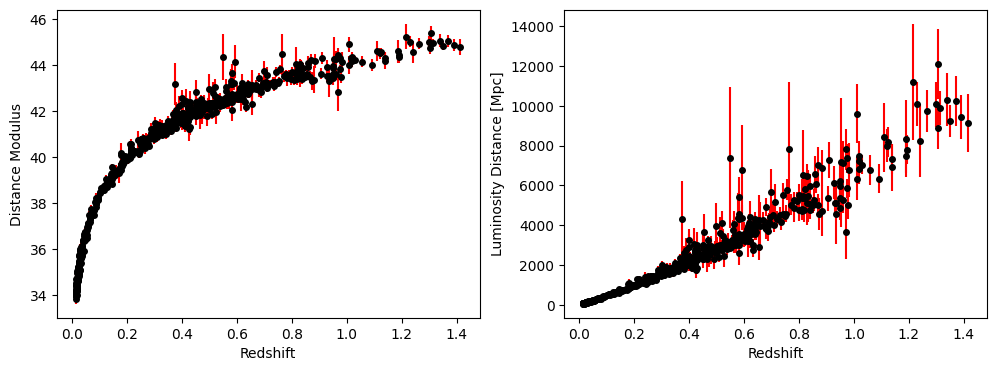

In [18]:
# Plotting data
# luminosity distance in pc
luminosity_distance_pc = 10. * 10.**(distance_modulus / 5.)

# In Mpc
luminosity_distance_Mpc = luminosity_distance_pc / 10.**6

# Error on distance:
error_luminosity_distance_Mpc = 5. * (10.**((distance_modulus + error_distance_modulus)/5.-6.) - 10.**((distance_modulus - error_distance_modulus)/5.-6.))


%matplotlib inline
plt.subplots(1, 2, figsize=(12, 4))

# Plot distance modulus versus redshift (original data)
plt.subplot(1, 2, 1)
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")
plt.errorbar(zs, distance_modulus,\
             yerr=error_distance_modulus,\
             fmt='o',\
             color='black',\
             ecolor='red',\
             markersize=4)

# Plot luminosity distance versus redshift
plt.subplot(1, 2, 2)
plt.xlabel("Redshift")
plt.ylabel("Luminosity Distance [Mpc]")
plt.errorbar(zs, luminosity_distance_Mpc,\
             yerr=error_luminosity_distance_Mpc,\
             fmt='o',\
             color='black',\
             ecolor='red',\
             markersize=4)

plt.show()

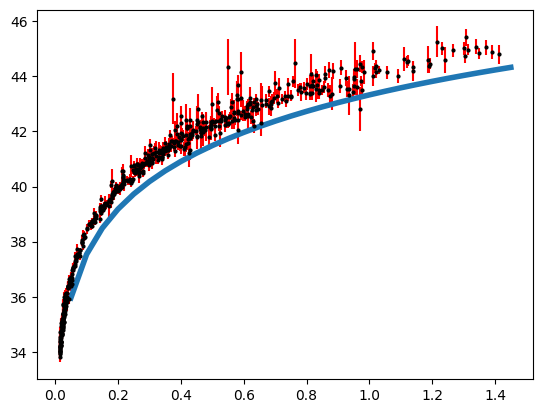

In [19]:
## Shall we see how the data compares to our model, withour naive choice of parameters?

plt.errorbar(zs, distance_modulus,\
             yerr=error_distance_modulus,\
             fmt='o',\
             color='black',\
             ecolor='red',\
             markersize=2)


OmegaL = 0.7
OmegaM = 0.3
H0     = 1.0 #0.7

modelzs = np.arange(0.05, 1.5, 0.05)
modelmus = []
for z in modelzs :
    modelmus += [mu(z, OmegaL, OmegaM, H0)]

plt.plot(modelzs, modelmus, linewidth=4)
plt.show()

In [23]:
# Markov-Chain
import math
# Number of accepted steps for Markov-Chain
N_steps = 20000

# Intial conditions
OmegaM = 0.5
OmegaL = 0.5
H0 = 0.5

# Chi squared

chi2_tot_old = 999999
chi2_tot_list = []

params = []
accepted_steps = 0

# Random Number Generator
rng = random.default_rng()

for i in range(N_steps) :

    log_OmegaM = np.log(OmegaM)
    log_OmegaL = np.log(OmegaL)
    log_OmegaM_n = log_OmegaM + np.random.normal(0, 0.01) # New value for log-transformed parameters
    log_OmegaL_n = log_OmegaL + np.random.normal(0, 0.01) # New value for log-transformed parameters

    # Transform to original space
    OmegaM_n = np.exp(log_OmegaM_n)
    OmegaL_n = np.exp(log_OmegaL_n)

    H0_n = H0 + np.random.normal(0, 0.05) # New H0 value

    if(OmegaM_n < 0.0) : continue
    if(H0_n < 0.0) : continue

    # Datapoints loop
    chi2_tot = 0.
    for j in range(len(zs)) :
        mu_model = mu(zs[j], OmegaL_n, OmegaM_n, H0_n)
        chi2 = (mu_model - distance_modulus[j])**2 / error_distance_modulus[j]**2
        chi2_tot += chi2

    if np.isnan(chi2_tot) : continue

    accept_bar = rng.random() # 0 or 1
    chifactor = chi2_tot_old - chi2_tot; # Difference in chi squared between new and old theta

    if chifactor >= 20:
        chifactor = 20;

    # Ratio of likelihoobs
    accept_coefficient = math.exp((chifactor) / 2.0)

    if accept_bar < accept_coefficient :

        accepted_steps += 1

        print("Accepting", chi2_tot, "since", accept_bar, "<", accept_coefficient, "run number:", i, "/", N_steps)

        OmegaM = OmegaM_n
        OmegaL = OmegaL_n
        H0       = H0_n
        chi2_tot_old = chi2_tot

        params.append([OmegaM, OmegaL, H0]) # Adding theta to array

# Print list
for i in range(len(params)):
    print(i, "| Omegam:", params[i][0], "Omegal:", params[i][1], "H0:", params[i][2])

params = params[9:]
h_arr = np.array([])
OmegaM_arr = np.array([])
OmegaL_arr = np.array([])

for param in params:
    OmegaM_arr = np.append(OmegaM_arr, param[0])
    OmegaL_arr = np.append(OmegaL_arr, param[1])
    h_arr = np.append(h_arr, param[2])
#print the number of acepted steps
print ('Number of accetped steps:', accepted_steps, 'Acceptance ratio:', accepted_steps/N_steps)

Accepting 18451.19844184116 since 0.8116180636429893 < 22026.465794806718 run number: 0 / 20000
Accepting 14608.185029029082 since 0.25907814913754035 < 22026.465794806718 run number: 3 / 20000
Accepting 11882.104082652 since 0.31452063547438014 < 22026.465794806718 run number: 5 / 20000
Accepting 6184.853966306483 since 0.6111800326354196 < 22026.465794806718 run number: 7 / 20000
Accepting 1377.386863953321 since 0.9303112830650548 < 22026.465794806718 run number: 8 / 20000
Accepting 1380.4804962766098 since 0.0179936154552075 < 0.21292481396976098 run number: 9 / 20000
Accepting 1206.2951772500826 since 0.045696681273407425 < 22026.465794806718 run number: 11 / 20000
Accepting 1164.0116225049487 since 0.9704119176575859 < 22026.465794806718 run number: 12 / 20000
Accepting 685.582840205027 since 0.1447346714315555 < 22026.465794806718 run number: 18 / 20000
Accepting 651.1778955512877 since 0.6592416038209341 < 22026.465794806718 run number: 32 / 20000
Accepting 650.789586406597 sin

Removed no burn in
0.7  <  h  <  0.71  at  68 % CL
0.35  <  OmegaM  <  0.43  at  68 % CL
0.73  <  OmegaL  <  0.97  at  68 % CL
-0.38  <  Omegak  <  -0.05  at  68 % CL




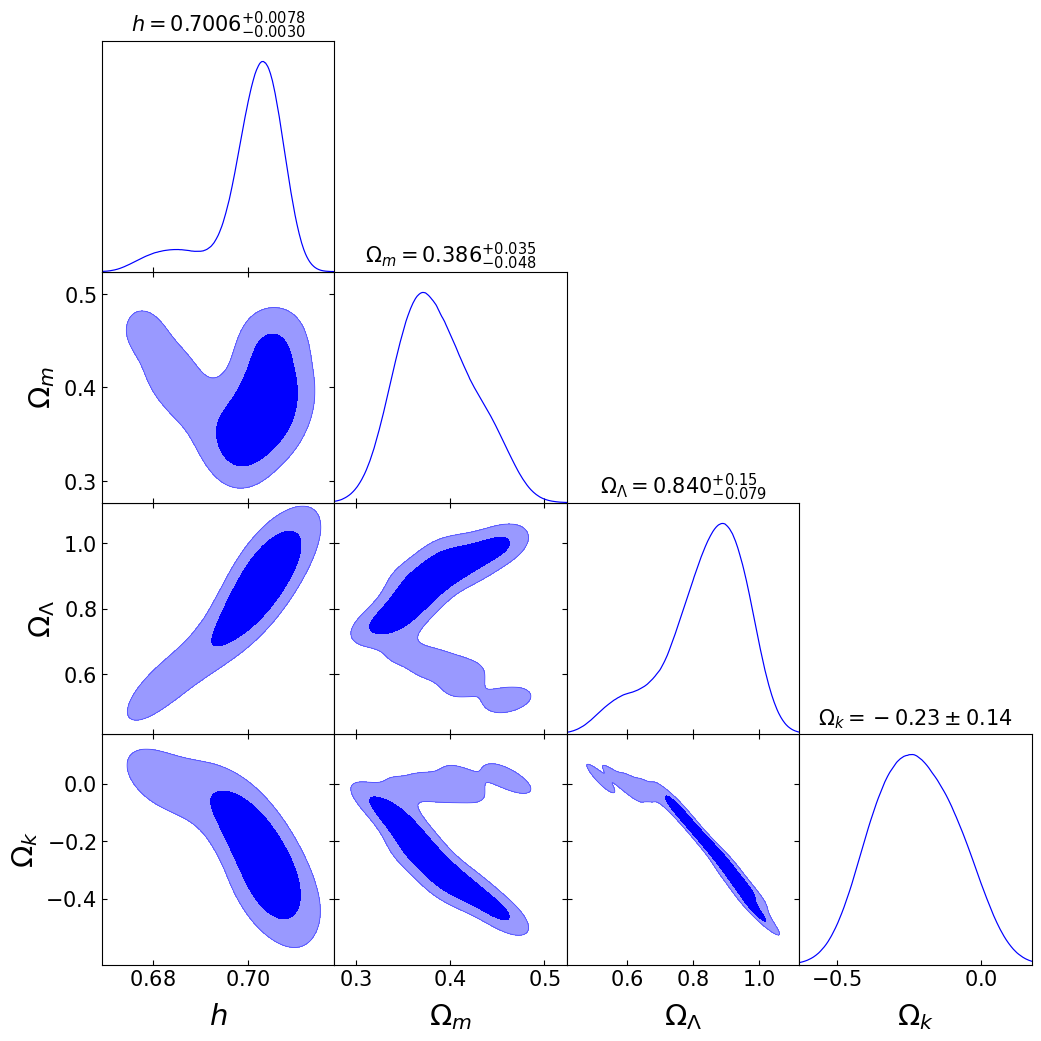

In [30]:
%matplotlib inline
# np.arrays as functions other np.arrays
Omegak_arr = 1. - OmegaM_arr - OmegaL_arr

# Variable names and labels
my_labels = [r'h', r'\Omega_m', r'\Omega_\Lambda', r'\Omega_k']
my_names = ['h', 'OmegaM', 'OmegaL', 'Omegak']
my_dim = len(my_names)

# Gigher-dimensional array with all data
my_samples = np.transpose(np.reshape([h_arr, OmegaM_arr, OmegaL_arr, Omegak_arr], (my_dim, len(h_arr))))
my_samples = MCSamples(samples = my_samples, labels = my_labels, names = my_names)

conf_level = 0.6827 # 1-sigma confidence level

# Table with the 1D posteriors
for nam in my_names:
    print(round(my_samples.confidence(nam,(1.-conf_level)/2.,upper=False),2), \
          " < ", nam , " < ", round(my_samples.confidence(nam,(1.-conf_level)/2.,upper=True),2),\
          " at " , int(100*conf_level),"\b% CL")
print("\n")

# Triangle corner plot
contour_colors = ['blue']
j = plots.getSubplotPlotter(subplot_size=3)
j.settings.axes_labelsize = 22
j.settings.axes_fontsize = 16
j.triangle_plot(my_samples, filled = True, title_limit=1, contour_colors=contour_colors)